## The Clark-Wright Savings Algorithm

The savings algorithm aims to find a solution to the Vechile Routing Problem (VRP). It starts off with a trivial solution where there are $n$ vehicles which deliver to $n$ nodes. It then merges routes based on the highest possible savings per merge. The idea is to be able to start with the image on the left and move to the image on the right. 

<img src=img/clark.png width="300" height="200" / >


Basically the algorithm can be understood as follows: 
<ol>
  <li>Start off with a trivial solution to the problem. That is, have one vechicle travel from the depot to each node.</li>
  <li>Create a savings matrix such that s(i, j) = distance(i, depot) + distance(depot, j) - distance(i, j)</li>
  <li>Sort your savings matrix so you consider the pairs with the highest savings first</li>
  <li>Merge those nodes if they meet all the feasibility constraints</li>
</ol>         


TODO

1. Change old code where it treats segments as tuples 
2. Segment should have none as second carry in 
3. Hardcoded distance between 218 and 999, and ep1, prep2 ... 

# Reading in Data

In [246]:
import pandas as pd
import numpy  as np
from graph import Graph
from segment import Segment

In [247]:
# Reading Data
#timedf             = pd.read_csv('data/PrepSiteTimeMatrix.csv', header=0, index_col=0)
prep_carry_matches = pd.read_csv('data/prep-carry-matches2.csv')
delivery_times     = pd.read_csv('data/delivery-times2.csv')
timematrix         = pd.read_csv('data/time_matrix.csv')
prep_carry_matches = prep_carry_matches.fillna(0)

# Getting Ready for Savings Algorithm
We need to create some functions and prepare the data before we can get started.

## Creating Segments
Here, we're building the segments based on the given matching guidelines. That is, if some prep site delivers to some carry in sites, that's one segment.

In [248]:
# Defining all the segments. Each segment has one prep site, one/two carry-in sites, and one timewindow
#
# Ex: Segment 0 -> Prep Site = 450 | Carry-Ins = [604,] | Time-Window = (6:15, 7:15)
#     Segment 1 -> Prep Site = 450 | Carry-Ins = [604,] | Time-Windwo = (9:30, 10:30)
segments = []
segmentstup = []
for i in prep_carry_matches.values.tolist():
    obj = Segment(int(i[0]), int(i[1]), int(i[2]))
    tup = (int(i[0]), int(i[1]), int(i[2]))
    segments.append(obj)
    segmentstup.append(tup)

## Creating Distance Function
This is to help us later. We have a csv file with the times from each school to another. So, to simplify accesing these times, we're creating a function, `distance(src, dst)` which takes in two school's three digit codes and returns the time it takes to go from one to the next.

In [249]:
# Creating a distance function from the distance matrix
# Given two school's 3 digit codes, it returns the distance in time between them
# Ex: distance(981, 604) = 35.736
origin      = list(timematrix['ODLines1_Origin_School'])
destination = list(timematrix['ODLines1_Destination_School'])
times       = list(timematrix['ODLines1_Total_TravelTime'])

pairs = zip(origin, destination, times)
distance_dictionary = {}
for src, dst, time in pairs:
    distance_dictionary[(src, dst)] = time

def distance(src_, dst_):
    return distance_dictionary[(src_, dst_)]

## Creating Time Windows


This part is a bit trickier. We need to create time windows for each of the segments. These are going to be used when we execute the savings algorithm to make sure we compute feasible routes. The time window for each segment is defined to be 

~~~
(start = earliest time any carryin is visted, end = earliest time any carryin is left)
~~~

In [250]:
# Given a carryin site, it returns the scheulde for it's breakfast and lunch
def time_lookup(carryin_):
    for i in delivery_times.values:
        if i[0] == carryin_:
            return list(i)
    raise Exception(f'carryin site {carryin_} not found')

In [251]:
# Given two start and end times, it converts the earliest of each to datetime format and returns it.
def strict_window(start, end, start2 = 0, end2 = 0):
    if start == 'DIA':
        start = '6:00 AM'
    if start2 == 'DIA':
        start2 = '6:00 AM'

    if start2 == 0 and end2 == 0:
        return (pd.to_datetime(start), pd.to_datetime(end))
    start  = pd.to_datetime(start)
    start2 = pd.to_datetime(start2)
    end    = pd.to_datetime(end)
    end2   = pd.to_datetime(end2)
    if start2 < start:
        start = pd.to_datetime(start2)

    if end2 < end2:
        end = pd.to_datetime(end2)

    return(start, end)

In [252]:
# Given all segments (assuming they have one or two carry-in sites), it builds time windows for those segments 
# It returns a dictionary which maps segments to time windows
def window_builder(segments_):
    seen = {}
    windows = {}
    visited = {}
    for segment_ in segments_:
        for carry in segment_[1:]:
            if carry not in visited:
                visited[carry] = 1
            else:
                visited[carry] += 1

    # For every segment, find the time constraints for the first carryin according to delivery_times.csv
    for indx,segment_ in enumerate(segments_):
        carryin1 = segment_[1]
        carryin2 = segment_[2]

        i = time_lookup(carryin1)
        # If breakfast is delivered a day in advance, there is no breakfast, or we've already accounted for breakfast,
        # then this segment adheres to the lunch time schedule
        if visited[i[0]] == 2:
            start = i[1]
            end   = i[2]
            visited[i[0]] -= 1
        else:
            start = i[3]
            end   = i[4] 
        # If the next carry in is 0 (meaning there is only one carry in) then just add the window and move on
        if carryin2 == 0: 
            windows[indx] = strict_window(start, end)
            continue

        # If there is a second carry-in site, explore that one as well
        i = time_lookup(carryin2)
        if visited[i[0]] == 2:
            start2 = i[1]
            end2   = i[2]
            visited[i[0]] -= 1
        else:
            start2 = i[3]
            end2   = i[4] 
        # For segments which have two carry ins - find the approriate start and end time of the window
        windows[indx] = strict_window(start, end, start2, end2)
    return windows

## Creating Service Times
Here, we need to determine how long it takes to service every segment. 

- If we're visiting just one carryin site it's going to be 

        distance(prep, carry) + buffer

 - If we're visiting two carryin sites, then it'll be 

        min(distance(prep,carry1), distance(prep,carry2)) + distance(carry1, carry2) + 2*buffer

What does that mean? It's saying the service time is the time it takes to go from the prep site to the closest carryin site and then going to the next carry in. The buffer is the time to unload the food. We have to do it twice when there's two carryins

In [253]:
# Calculates the service time for a segment given a buffer (unloading time)
def service_time_calc(segment_, buffer_):
    if segment_.carry2 == 0:
        return distance(segment_.prep, segment_.carry1) + buffer_
    return min(distance(segment_.prep, segment_.carry1), distance(segment_.prep, segment_.carry2)) + 2*buffer_

## Updating Segments 
Up until now, we did a lot of prep work for our segments. Here, we're putting it together so each `Segment()` object has its corresponding time window and service times. 

In [260]:
# Adding time_window and service_time fields to every segment
buffer = 5
seg_windows = window_builder(segmentstup)
for indx,seg in enumerate(segments):
    seg.time_window = seg_windows[indx]
    seg.service_time = service_time_calc(seg, buffer)

# Modified Savings Algorithm 
All the prep work is in place. We're ready to code the modified savings algorithm. A 

In [232]:
## Calculates the savings from merging two prep sites i, j. 
def savings(prep_, depot_, distance_):
    savings = []
    for i in prep_:
        if i == depot_: continue
        for j in prep_:
            if (j==depot_) or (i==j): 
                continue 
            i_cost = distance(i, depot_)
            j_cost = distance(depot_, i)
            ij_cost = distance(i, j)
            save = i_cost + j_cost - ij_cost
            savings.append(((i,j), save))
    return savings

In [229]:
# Getting prep sites
# Expressing distance matrix as list of lists 
# Marking the depot as having code '0'
prep = timedf.index.values 
dist = [list(i) for i in list(timedf.values)]
depot = 0 

In [230]:
## Building a dictionary which maps a prep site's 3 digit code to it's node in the graph
## site_to_indx[174] -> 0
site_to_indx = {}
for indx, site in enumerate(prep):
    site_to_indx[site] = indx

In [231]:
## Takes two prep sites and returns the distance between them. Distances are not symetrical. 
## (174, 1109) -> 14.74
## (1109, 174) -> 15.59
def distance(i, j):
    return dist[site_to_indx[i]][site_to_indx[j]]

In [233]:
## Sort the savings such that highest savings is on bottom
savings_ls = savings(prep, depot, dist)
savings_ls.sort(key=lambda tup: tup[1])

KeyError: 0

In [234]:
## Creating a graph and applying the savings algorithm
graph = Graph(prep, depot)
i = 0
while i<1000:
    x = savings_ls.pop()
    node1 = x[0][0]
    node2 = x[0][1]
    if not graph.is_node_interior(node1) and not graph.is_node_interior(node2):
        if not graph.on_same_route(x[0]):
            graph.merge(x[0])
    i += 1

NameError: name 'savings_ls' is not defined

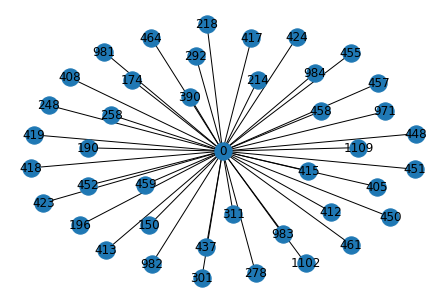

In [235]:
# libraries
import networkx as nx
import matplotlib.pyplot as plt
 
# Build the dataframe for the graph
selected_arcs = list(graph.arcs)
start = [i[0] for i in selected_arcs]
end = [i[1] for i in selected_arcs]
df = pd.DataFrame({ 'from':start, 'to':end})
 
# Build your graph
G=nx.from_pandas_edgelist(df, 'from', 'to')
 
 
# Plot it
nx.draw(G, with_labels=True)
plt.show()
